# **Case Study: Cyclistic Bike-Share Analysis**
**Author:** AzharFachrezi | **Date:** Jan 2026 | **Tool:** Python (Pandas)

## **Executive Summary**
**Goal:** Design marketing strategies to convert casual riders into annual members.
**Key Finding:** Casual riders use bikes for leisure on weekends, while members use them for commuting on weekdays.
**Recommendation:** Introduce a "Weekend Warrior" membership tier to target casual riders during their peak usage times.

---

## **Phase 1: Prepare & Process**
I am using **Pandas** for data manipulation and **Matplotlib/Seaborn** for visualization.
The dataset consists of 12 months of historical trip data (2019 Q1 and 2020 Q1), which I will merge into a single dataframe for analysis.

In [108]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [109]:
# Load The Datasets
data1 = "Divvy_Trips_2019_Q1.csv"
data2 = "Divvy_Trips_2020_Q1.csv"

df_2019 = pd.read_csv(data1)
df_2020 = pd.read_csv(data2)

pd.set_option("display.max_columns", None)

print(f"Columns from df_2019: {len(df_2019.columns)}")
print(df_2019.columns)
print(f"Columns from df_2020: {len(df_2020.columns)}")
print(df_2020.columns)

Columns from df_2019: 12
Index(['trip_id', 'start_time', 'end_time', 'bikeid', 'tripduration',
       'from_station_id', 'from_station_name', 'to_station_id',
       'to_station_name', 'usertype', 'gender', 'birthyear'],
      dtype='object')
Columns from df_2020: 13
Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


---

### **Data Cleaning & merging**
It seems that the datasets from 2019 and 2020 have different column names (e.g., `trip_id` vs `ride_id`). <br>
**Solution:** I renamed the 2019 columns to match the 2020 standard before merging them. I also standardized the "User Type" labels to ensure consistency.

In [30]:
# Define the columns mapping
rename_map = {
    'trip_id': 'ride_id',
    'start_time': 'started_at',
    'end_time': 'ended_at',
    'usertype': 'member_casual',
    'from_station_name': 'start_station_name',
    'from_station_id': 'start_station_id',
    'to_station_name': 'end_station_name',
    'to_station_id': 'end_station_id'
}

# Apply mapping to df_2019
df_2019.rename(columns=rename_map, inplace=True)

# Handle Extra Columns
# df_2019 has 'gender' and 'birthyear', but df_2020 does not.
# I'll drop it to match df_2020 structure and privacy reasons.
df_2019_clean = df_2019[df_2020.columns.intersection(df_2019.columns)]
df_2020_clean = df_2020[df_2019_clean.columns]

In [38]:
# Combine two dataframe to one
df_combined = pd.concat([df_2019_clean, df_2020_clean], ignore_index=True)

# Check the result
print(f"Total rows: {len(df_combined)}")
df_combined.head()

Total rows: 791956


,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual
0,21742443,2019-01-01 0:04:37,2019-01-01 0:11:07,Wabash Ave & Grand Ave,199,Milwaukee Ave & Grand Ave,84.0,Subscriber
1,21742444,2019-01-01 0:08:13,2019-01-01 0:15:34,State St & Randolph St,44,Dearborn St & Van Buren St (*),624.0,Subscriber
2,21742445,2019-01-01 0:13:23,2019-01-01 0:27:12,Racine Ave & 18th St,15,Western Ave & Fillmore St (*),644.0,Subscriber
3,21742446,2019-01-01 0:13:45,2019-01-01 0:43:28,California Ave & Milwaukee Ave,123,Clark St & Elm St,176.0,Subscriber
4,21742447,2019-01-01 0:14:52,2019-01-01 0:20:56,Mies van der Rohe Way & Chicago Ave,173,Streeter Dr & Grand Ave,35.0,Subscriber


In [43]:
# Fix 'member_casual' column values
# 'Subscriber' = 'member', and 'Customer' = 'casual'
df_combined['member_casual'] = df_combined['member_casual'].replace({
    'Subscriber' : 'member',
    'Customer' : 'casual'
})

# Fix datetime columns
df_combined['started_at'] = pd.to_datetime(df_combined['started_at'])
df_combined['ended_at'] = pd.to_datetime(df_combined['ended_at'])


---

### **Feature Engineering**
To answer the business question, I need to calculate two key metrics:
1.  **Ride Length:** How long did each trip last?
2.  **Day of Week:** On which days are bikes used most?

*Note: I will filter out any "bad data" (negative ride lengths) caused by system errors.*

In [ ]:
# Create 'ride_length' column
df_combined['ride_length'] = df_combined['ended_at'] - df_combined['started_at']

# Create a "minutes" column for more details
df_combined['ride_length_minutes'] = df_combined['ride_length'].dt.total_seconds()/60

# Create "day-of-week" column
df_combined['day_of_week'] = df_combined['started_at'].dt.day_name()

In [51]:
# Check if there's negative time values (Bad Data)
df_combined[df_combined['ride_length_minutes'] < 0]['ride_length_minutes'].count()

117

In [53]:
# Remove those negative time values
df_final = df_combined[df_combined['ride_length_minutes'] > 0].copy()

# Verify again
df_final[df_final['ride_length_minutes'] < 0]['ride_length_minutes'].count()

0

In [54]:
# Check for missing values
df_final.isna().sum()

ride_id                0
started_at             0
ended_at               0
start_station_name     0
start_station_id       0
end_station_name       0
end_station_id         0
member_casual          0
ride_length            0
ride_length_minutes    0
day_of_week            0
dtype: int64

---

## **Phase 2: Analyze**
Now that the data is clean, let's look for behavioral differences.
I will aggregate the data by **User Type** (Member vs. Casual) to compare:
* Average Ride Duration
* Ride Frequency by Day of Week

In [66]:
# Summary Stats
mean_ride_length = df_final['ride_length_minutes'].mean()
max_ride_length = df_final['ride_length_minutes'].max()
mode_day_of_week = df_final['day_of_week'].mode()

summary_stats = pd.DataFrame({
    'mean_ride_length' : mean_ride_length,
    'max_ride_length' : max_ride_length,
    'mode_day_of_week' : mode_day_of_week
})

summary_stats

,mean_ride_length,max_ride_length,mode_day_of_week
0,19.735499,177200.366667,Tuesday


In [57]:
# -- Compare Ride Length for each User Type ---
ride_length_stats = df_final.groupby('member_casual')['ride_length_minutes'].agg(['mean', 'median', 'count'])

print("--- User Type Comparison ---\n")
print(ride_length_stats)

--- User Type Comparison ---

                    mean     median   count
member_casual                              
casual         85.091464  22.066667   71433
member         13.254188   8.466667  720313


**Casual** users have much *longer* average ride times (leisure), while **Member** have shorter ride times (commuting).

In [78]:
# Check "Weekly Rountine"

# First re-order the 'day of week' column and convert it to categorical column
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_final['day_of_week'] = pd.Categorical(df_final['day_of_week'], categories=day_order, ordered=True)

# Aggregates ride length per user type and day
weekly_trends = df_final.groupby(['member_casual', 'day_of_week'], observed=True).size().unstack()

weekly_trends

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
member_casual,,,,,,,
casual,6694,7972,8363,7771,8508,13473,18652
member,110430,127974,121903,125228,115168,59413,60197


In [80]:
# Check "Weekly Duration"

weekly_duration = df_final.groupby(['member_casual', 'day_of_week'], observed=True)['ride_length_minutes'].mean().unstack().round(2)

weekly_duration

day_of_week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
member_casual,,,,,,,
casual,66.16,69.73,68.67,129.55,95.61,82.51,84.36
member,13.71,12.82,11.87,11.79,13.28,16.23,16.22


---

## **Phase 3: Share (Visualizations)**
The data reveals a clear distinction in behavior:
* **Members** stick to a strict weekday routine (Commuting).
* **Casuals** dominate the weekends (Leisure).

Let's visualize this trend.

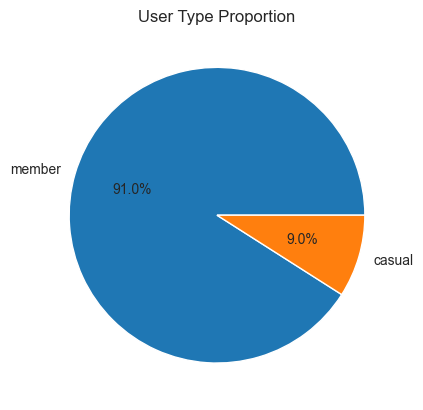

In [92]:
count_member = df_final['member_casual'].value_counts()
plt.pie(x=count_member, autopct="%1.1f%%", labels=count_member.index)

plt.title("User Type Proportion")

plt.show()

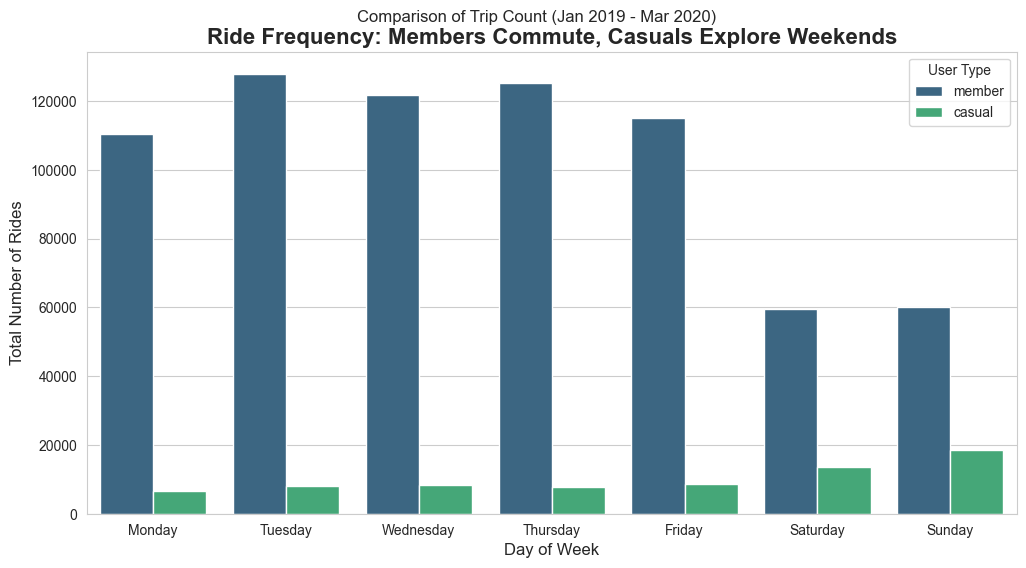

In [112]:
# "Frequency" Chart
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_final, 
    x='day_of_week', 
    hue='member_casual',
    palette='viridis' # Professional color scheme
)

# 3. Add Context (The "Share" Phase requirements)
plt.title("Ride Frequency: Members Commute, Casuals Explore Weekends", fontsize=16, fontweight='bold')
plt.suptitle("Comparison of Trip Count (Jan 2019 - Mar 2020)", y=0.95)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Total Number of Rides", fontsize=12)
plt.legend(title='User Type')

# 4. Save for GitHub
plt.savefig('Visualization/ride_frequency.png', dpi=300)
plt.show()

>The data suggests that `Casual` users ride primarily on weekends for leisure, whereas `Members` use the service mostly on weekdays, likely for commuting.

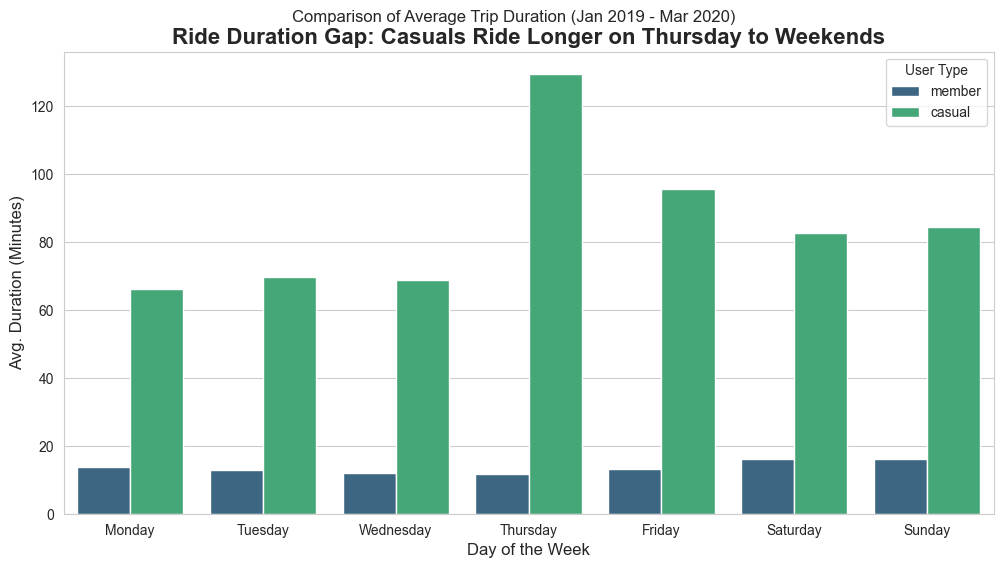

In [111]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df_final, x='day_of_week', y='ride_length_minutes', 
            hue='member_casual', palette='viridis', estimator='mean', errorbar=None)

# Title and Labels
plt.title("Ride Duration Gap: Casuals Ride Longer on Thursday to Weekends", fontsize=16, fontweight='bold')
plt.suptitle("Comparison of Average Trip Duration (Jan 2019 - Mar 2020)", y=0.95) # Subtitle
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Avg. Duration (Minutes)", fontsize=12)
plt.legend(title='User Type')

plt.savefig('Visualization/average_trip_duration.png', dpi=300)
plt.show()

>`Casual` riders show a clear preference for longer trips from Thursday through the weekend, whereas `Member` ride duration shows minimal fluctuation throughout the week.

---

## **Phase 4: Act (Recommendations)**
Based on the analysis, I recommend the following actions:
1.  **Target Weekends:** Launch a weekend-only pass to capture the high volume of casual riders.
2.  **Thursday Promos:** Since casuals ride longest on Thursdays, offer special incentives for long rides on this day.
3.  **Commuter conversion:** marketing campaign for casual riders who ride on weekdays.